In [3]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

n = 2
grover_circuit = QuantumCircuit(n)

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc

grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     └───┘

In [4]:
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()

┌───┐   
q_0: ┤ H ├─■─
     ├───┤ │ 
q_1: ┤ H ├─■─
     └───┘

In [5]:
# Diffusion operator (U_s)
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()

┌───┐   ┌───┐┌───┐   ┌───┐
q_0: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     ├───┤ │ ├───┤├───┤ │ ├───┤
q_1: ┤ H ├─■─┤ H ├┤ Z ├─■─┤ H ├
     └───┘   └───┘└───┘   └───┘

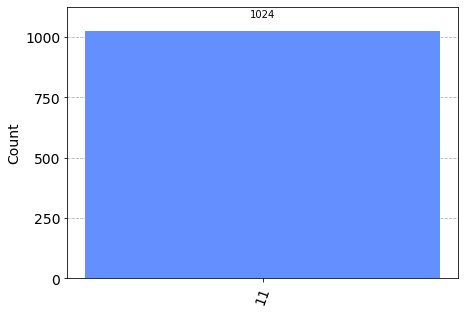

In [6]:
grover_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

Now, we implement the same for 3 qubits.

In [7]:
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

In [8]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [9]:
n = 3
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()

┌───┐┌─────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0            ├┤0       ├─░─┤M├──────
        ├───┤│             ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U$_\omega$ ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│             ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2            ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────────────┘└────────┘ ░  ║  ║ └╥┘
meas_0: ══════════════════════════════════╩══╬══╬═
                                             ║  ║ 
meas_1: ═════════════════════════════════════╩══╬═
                                                ║ 
meas_2: ════════════════════════════════════════╩═

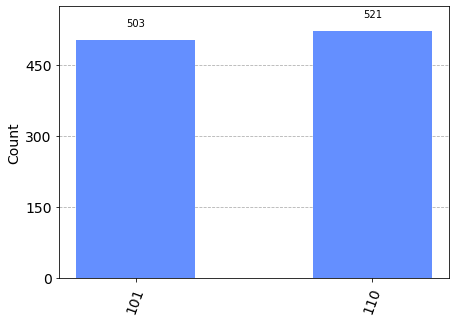

In [10]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)